# HW2Q7 c
### import library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

### constants

In [2]:
EPSILON = 0.01
MAX_ITER = 1000000
RHO = 0.01

### functions

In [3]:
def phi_func(row, n_degree):
    """
    This is the phi function that apply to each row
    """
    if n_degree == -1:
        return row
    else:
        result = np.array([])
        for i in row:
            for j in range(1, n_degree + 1):
                result = np.concatenate([result, [np.power(i, j)]])
        return np.concatenate([result, [1]])


def feature_normalization(trn, tst, val):
    """
    This function normalize all training, testing and validation sets.
    It normalize the testing and validation sets with parameter computed from training set.
    """
    for i in range(0, len(trn[0]) - 1):
        avg, max_minus_min = normalize_helper(trn[:, [i]]) 
        trn[:, [i]] = (trn[:, [i]] - avg) / max_minus_min
        tst[:, [i]] = (tst[:, [i]] - avg) / max_minus_min
        val[:, [i]] = (val[:, [i]] - avg) / max_minus_min
    return trn, tst, val


def normalize_helper(colum):
    """
    calculates the mean and range
    """
    avg = np.mean(colum)
    max_minus_min = np.max(colum) - np.min(colum)
    return avg, max_minus_min


def linear_reg(data, s, lam_da, n_degree=-1, gd_rho=RHO):
    """
    The main function of linear regression
    input s = 1 to do gradient descent and s = 0 to do closed form
    """
    data_copy = data.copy()
    for key in ['X_trn', 'X_tst', 'X_val']:
        data_copy[key] = np.apply_along_axis(phi_func, 1, data_copy[key], n_degree)
    # feature normalization:
    x_trn = data_copy['X_trn']
    x_tst = data_copy['X_tst']
    x_val = data_copy['X_val']
    x_trn, x_tst, x_val = feature_normalization(x_trn, x_tst, x_val)
    data_copy['X_trn'] = x_trn
    data_copy['X_tst'] = x_tst
    data_copy['X_val'] = x_val
    # start regression:
    if s == 0:
        return (data_copy,) + closed_form_reg(data_copy, lam_da)
    elif s == 1:
        return (data_copy,) + gradient_descent_reg(data_copy, lam_da, rho=gd_rho)


def closed_form_reg(data, lam_da):
    """
    wrapper of closed form regression.
    Calculate the learning result, then calculate the errors
    """
    theta_star = closed_form_theta(data, lam_da)
    err_trn, err_tst, err_val = calc_error(data, theta_star)
    return theta_star, err_trn, err_tst, err_val


def closed_form_theta(data, lam_da):
    """
    calculate optimal theta from training data and given lambda
    """
    x_trn = data['X_trn']
    y_trn = data['Y_trn']
    xtx = np.matmul(x_trn.transpose(), x_trn)
    l_id = lam_da * np.eye(len(xtx[0]), dtype=float)
    inv = np.linalg.inv(xtx + l_id)
    theta_star_mat = np.matmul(inv, np.matmul(x_trn.transpose(), y_trn))
    return theta_star_mat


def calc_error(data, theta):
    """
    Calculating errors of training, testing and validation sets
    """
    x_train = data['X_trn']
    x_test = data['X_tst']
    x_val = data['X_val']
    y_train = data['Y_trn']
    y_test = data['Y_tst']
    y_val = data['Y_val']
    err_train = calc_error_xytheta(x_train, y_train, theta)
    err_test = calc_error_xytheta(x_test, y_test, theta)
    err_val = calc_error_xytheta(x_val, y_val, theta)
    return err_train, err_test, err_val


def calc_error_xytheta(x_mat, y_mat, theta_mat):
    """
    A helper that calculates the errors given PHI(X), Y and optimal theta
    """
    err_mat = np.subtract(y_mat, np.matmul(theta_mat.transpose(), x_mat.transpose()).transpose())
    err = np.power(np.linalg.norm(err_mat), 2) / len(err_mat)
    return err


def gradient_descent_reg(data, lamb_da, max_iter=MAX_ITER, rho=RHO, epsilon=EPSILON):
    """
    The main function that does the gradient descent.
    """
    x_train = data['X_trn']
    y_train = data['Y_trn']
    curr_theta = np.full((len(x_train[0]), 1), 0)
    i = 1
    for i in range(0, max_iter):
        new_theta, new_dir = single_descent(curr_theta, rho, x_train, y_train, lamb_da)
        curr_theta = new_theta
        if np.linalg.norm(new_dir) < epsilon:
            print("The total number of iterations is: {} with rho = {}".format(i + 1, rho))
            break
    if i >= max_iter - 1:
        print("Exceeds max iteration: {}; with learning rate: {}".format(max_iter, rho))
    err_trn, err_tst, err_val = calc_error(data, curr_theta)
    return curr_theta, err_trn, err_tst, err_val


def single_descent(curr_theta, rho, x, y, lamb_da):
    """
    compute a single descent with training data and given lambda
    """
    xt_x = np.matmul(x.transpose(), x)
    xt_y = np.matmul(x.transpose(), y)
    new_dir = (np.matmul(xt_x, curr_theta) - xt_y) + lamb_da * curr_theta
    theta = curr_theta - new_dir * rho
    return theta, new_dir


def plot_regression(data, theta, title=""):
    """
    Plots the regression result
    """
    # plot given data points
    x = data['x']
    y = data['y']
    x_first_col = x[:, [0]]
    plt.scatter(x_first_col, y)
    # plot given regression result theta
    theta_x = np.linspace(-1, 1)
    expanded_x = np.apply_along_axis(phi_func, 1, np.vstack(theta_x), len(theta) - 1)
    # normalizing linspace
    for i in range(0, expanded_x.shape[1] - 1):
        avg, max_minus_min = normalize_helper(expanded_x[:, [i]])
        expanded_x[:, [i]] = (expanded_x[:, [i]] - avg) / max_minus_min
    theta_y = np.matmul(expanded_x, theta)
    plt.plot(list(expanded_x[:, [0]]), list(theta_y))
    plt.title(title + " n = {}".format(theta.shape[0] - 1))
    plt.show()

### calculating theta on different lambdas
I am using the n-powering then normalizing method to compare lambdas.

I am only looking at the closed form result to decided which is the best lambda in the following code.

n = 7, lambda = 0.001
closed form calculation:
theta transpose = 
 [[-12.02177495  -2.28031535  11.26864355  -0.04746883   3.89040996
   -0.21904507  -3.01925951  -0.69673862]]
validation error: 0.02298079933690731


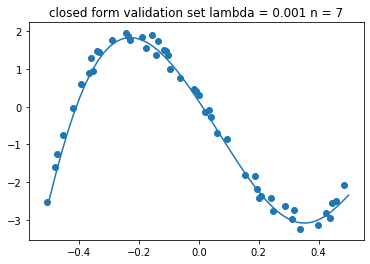

gradient descent calculation:
The total number of iterations is: 11919 with rho = 0.01
theta transpose = 
 [[-11.9301781   -2.2723808   10.93431306  -0.06482099   4.0865917
   -0.20978331  -2.94452463  -0.69673862]]
validation error: 0.022613312772216797


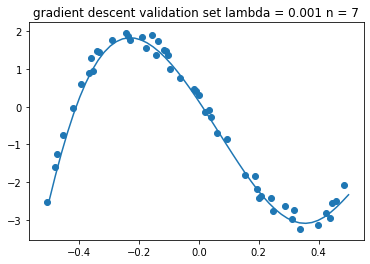



n = 7, lambda = 0.01
closed form calculation:
theta transpose = 
 [[-11.17331313  -2.19811369   8.9002535   -0.18623712   4.00157816
   -0.16275876  -1.38343455  -0.69663413]]
validation error: 0.02385600112687813


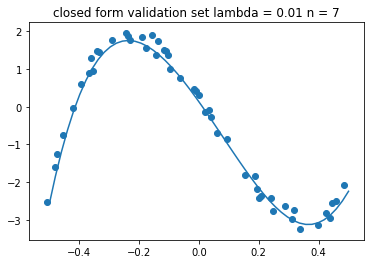

gradient descent calculation:
The total number of iterations is: 9263 with rho = 0.01
theta transpose = 
 [[-11.10998774  -2.19246094   8.70899703  -0.19825358   4.01015714
   -0.1567974   -1.24026461  -0.69663413]]
validation error: 0.024282624330997954


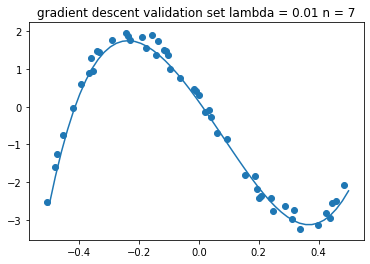



n = 7, lambda = 0.1
closed form calculation:
theta transpose = 
 [[-8.64560623 -1.89776091  3.26711063 -0.51987841  3.4624857  -0.09695454
   2.42308894 -0.69559092]]
validation error: 0.08922558827598198


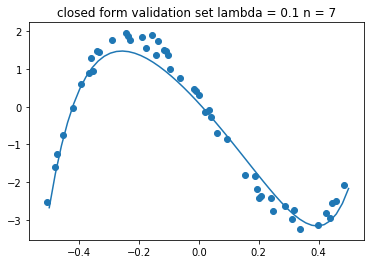

gradient descent calculation:
The total number of iterations is: 2870 with rho = 0.01
theta transpose = 
 [[-8.62619748 -1.89611749  3.2095945  -0.52330525  3.46161373 -0.09531616
   2.46948911 -0.69559092]]
validation error: 0.08995119350395128


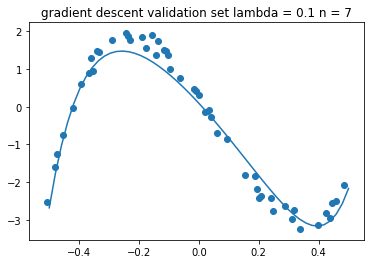



n = 7, lambda = 1
closed form calculation:
theta transpose = 
 [[-4.70284265 -1.22470657  0.24923209 -0.6502865   1.34229792 -0.35740805
   1.63340388 -0.6853281 ]]
validation error: 0.6382711477331524


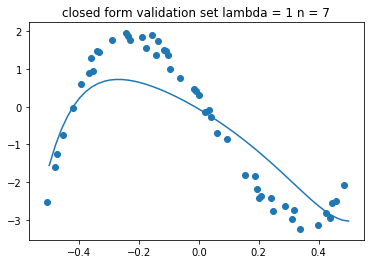

gradient descent calculation:
The total number of iterations is: 393 with rho = 0.01
theta transpose = 
 [[-4.6986762  -1.22391661  0.24322377 -0.65068824  1.34054624 -0.35772311
   1.63567034 -0.6853281 ]]
validation error: 0.639006086633026


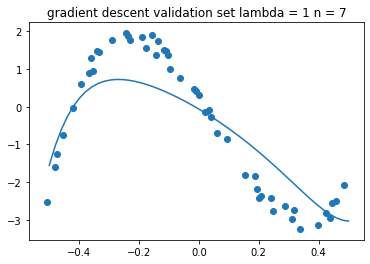



n = 7, lambda = 10
closed form calculation:
theta transpose = 
 [[-1.34899539 -0.53204657 -0.38805072 -0.43307085 -0.10392379 -0.35971099
   0.01143256 -0.59721449]]
validation error: 1.8932713618191497


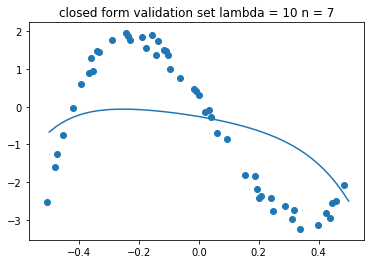

gradient descent calculation:
The total number of iterations is: 61 with rho = 0.01
theta transpose = 
 [[-1.34848954 -0.53196533 -0.38825586 -0.43307881 -0.10426445 -0.35975762
   0.01106846 -0.59721449]]
validation error: 1.8934873403410755


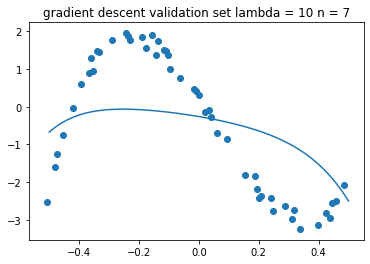



n = 7, lambda = 100
closed form calculation:
theta transpose = 
 [[-0.20642341 -0.10461187 -0.08676939 -0.09234815 -0.04730058 -0.0805544
  -0.02933348 -0.26128134]]
validation error: 2.9639952295544005


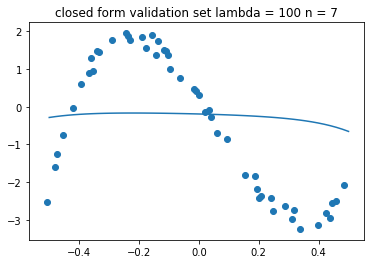

gradient descent calculation:
The total number of iterations is: 18 with rho = 0.01
theta transpose = 
 [[-0.20642341 -0.10461187 -0.08676939 -0.09234815 -0.04730058 -0.0805544
  -0.02933348 -0.2612548 ]]
validation error: 2.9640051444442204


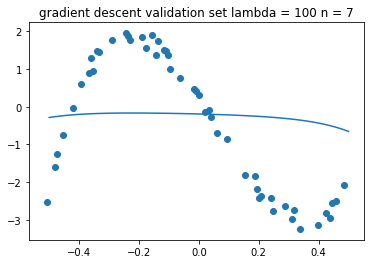

In [4]:
d1 = sio.loadmat('./data/dataset_hw2.mat')
# delete plain keys
d1.pop('__header__')
d1.pop('__version__')
d1.pop('__globals__')

closed_val_err_list = []
gd_val_err_list = []
lambda_list =  [0.001, 0.01, 0.1, 1, 10, 100]
for lamb_da in lambda_list:
    print('n = 7, lambda = {}'.format(lamb_da))
    # closed form:
    print("closed form calculation:")
    data_copy, theta_star, err_trn, err_tst, err_val = linear_reg(d1, 0, lamb_da, n_degree=7)
    closed_val_err_list.append(err_val)
    print("theta transpose = \n {}".format(theta_star.transpose()))
    print("validation error: {}".format(err_val))
    plot_regression({"x": data_copy['X_val'], "y": data_copy["Y_val"]}, theta_star, title="closed form validation set lambda = {}".format(lamb_da))
    # gradient descent:
    print("gradient descent calculation:")
    data_copy, theta_star, err_trn, err_tst, err_val = linear_reg(d1, 1, lamb_da, n_degree=7)
    gd_val_err_list.append(err_val)
    print("theta transpose = \n {}".format(theta_star.transpose()))
    print("validation error: {}".format(err_val))
    plot_regression({"x": data_copy['X_val'], "y": data_copy["Y_val"]}, theta_star, title="gradient descent validation set lambda = {}".format(lamb_da))
    print("\n")

### Draw the validation error as a function of the regularization parameter
The x label is -3, -2, -1, 1,2,3 each representing the power of 10. i.e. -3 -> 10^{-3}

NOTE: there is no data for 10^0

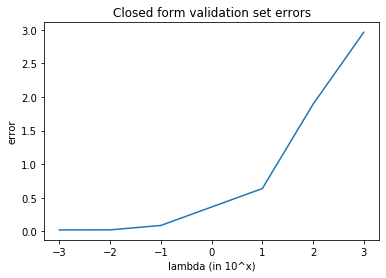

In [5]:
plt.plot(np.array([-3,-2,-1,1,2,3]), closed_val_err_list)
plt.title("Closed form validation set errors")
plt.xlabel('lambda (in 10^x)')
plt.ylabel('error')
plt.show()

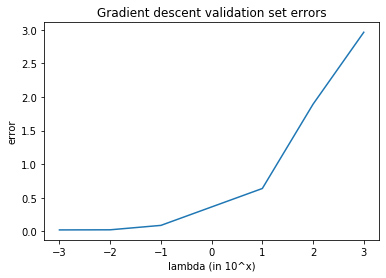

In [6]:
plt.plot(np.array([-3,-2,-1,1,2,3]), gd_val_err_list)
plt.title("Gradient descent validation set errors")
plt.xlabel('lambda (in 10^x)')
plt.ylabel('error')
plt.show()

**Following is the code for finding the best lambda**

Find the best lambda and then calculate the error on test sets.

In [7]:
min_err_lambda = lambda_list[np.argmin(closed_val_err_list)]
print('n = 7, lambda = {} gives the best result'.format(min_err_lambda))
print("closed form calculation:")
data_copy, theta_star, err_trn, err_tst, err_val = linear_reg(d1, 0, min_err_lambda, n_degree=7)
print("theta transpose = \n {}".format(theta_star.transpose()))
print("testing error: {}".format(err_tst))

n = 7, lambda = 0.001 gives the best result
closed form calculation:
theta transpose = 
 [[-12.02177495  -2.28031535  11.26864355  -0.04746883   3.89040996
   -0.21904507  -3.01925951  -0.69673862]]
testing error: 0.02391661269397512
